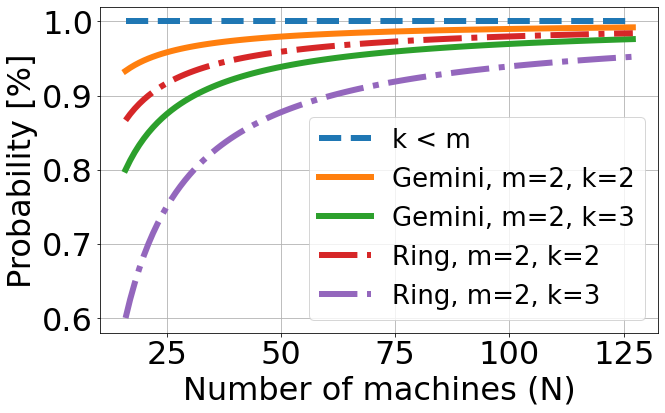

In [9]:
# Figure 9, the probability

import pandas as pd
import operator as op
import matplotlib.pyplot as plt
from functools import reduce



# calculate the value of combination function in Expresion (3)
def comb(n, r):
    if n == r:
        return 1
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

max_power = 7
nums = [i for i in range(2**4, 2**max_power)]


# the function to calculate the recovery probability with Ring placement strategy
def get_recovery_rate_ring(nums, m, k):
    """
        nums: the list of the number of instances involved in training
        m: the number of checkpoint replicas
        k: the number of machines that fail simultaneously
    """
    rates = []
    if k < m:
        return [1 for _ in nums]
    
    for num in nums:
        rate = num / comb(num, k) * comb(num-m, k-m)
        rates.append(1 - rate)
    return rates

# the function to calculate the recovery probability with Group placement strategy
def get_recovery_rate_group(nums, m, k):
    """
        nums: the list of the number of instances involved in training
        m: the number of checkpoint replicas
        k: the number of machines that fail simultaneously
    """
    rates = []
    if k < m:
        return [1 for _ in nums]
    
    for num in nums:
        rate = num / m / comb(num, k) * comb(num-m, k-m)
        rates.append(1 - rate)
    return rates

# when m = 2 and k = 1 with Group placement strategy
recovery_rate_group_2_1 = get_recovery_rate_ring(nums, 2, 1)
# when m = 2 and k = 2 with Ring placement strategy
recovery_rate_ring_2_2 = get_recovery_rate_ring(nums, 2, 2)
# when m = 2 and k = 3 with Ring placement strategy
recovery_rate_ring_2_3 = get_recovery_rate_ring(nums, 2, 3)
# when m = 2 and k = 2 with Group placement strategy
recovery_rate_group_2_2 = get_recovery_rate_group(nums, 2, 2)
# when m = 2 and k = 3 with Group placement strategy
recovery_rate_group_2_3 = get_recovery_rate_group(nums, 2, 3)


df = pd.DataFrame({
    'k < m': recovery_rate_group_2_1,
    'Gemini, m=2, k=2': recovery_rate_group_2_2,
    'Gemini, m=2, k=3': recovery_rate_group_2_3,
    'Ring, m=2, k=2': recovery_rate_ring_2_2,
    'Ring, m=2, k=3': recovery_rate_ring_2_3,
}, index=nums)

lines = df.plot.line(figsize=(10, 6), grid=True, lw=6, fontsize=32, style=[ '--', '-', '-', '-.', '-.', '--',])
lines.set_xlabel("Number of machines (N)", fontdict={'fontsize':32})
lines.set_ylabel("Probability [%]", fontdict={'fontsize':32})

# plt.ylim(75, 101)
plt.legend(loc=0, ncol=1, prop={'size': 26})
plt.savefig("Figure_9.png", bbox_inches='tight')

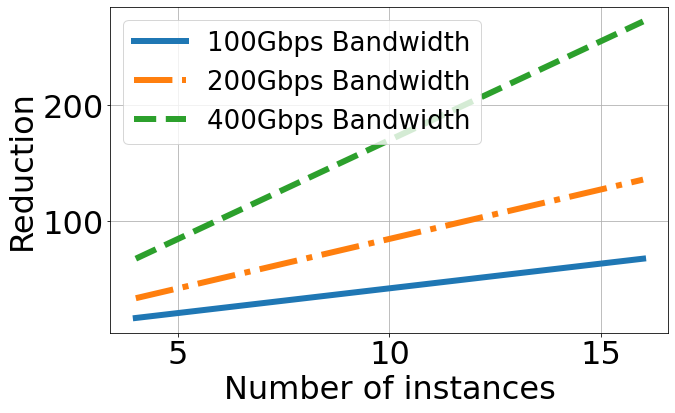

In [1]:
# Figure 11, checkpoint time reduction

import pandas as pd
import numpy
import matplotlib.pyplot as plt

# If you are in jupyter
%matplotlib inline

params = {'legend.fontsize': 26, 'font.size': 32}
plt.rcParams.update(params)

nums = numpy.array([4, 8, 12, 16])


def speedup_num(nums, remote_bandwidth, instance_bandwidth, m=2):
    """
        remote_bandwidth: the aggregated network bandwidth connecting GPU instances to remote storage system
        instance_bandwidth: the network bandwidth connecting GPU instances
        m: the number of checkpoint replicas
    """
    checkpoint = []
    for num in nums:
        csp = instance_bandwidth / (remote_bandwidth / num)  / (m-1) 
        checkpoint.append(csp)

    return checkpoint

# the aggregated network bandwidth connecting GPU instances to remote storage system is 20Gbps in our testbed
remote_bandwidth = 20
# Based on my measurement in AWS, the network utilization is around 0.85.
# Suppose the instance bandwidth is 400Gbps, the achieved throughput is around 400*0.85=340Gbps
network_utilization = 0.85

# the checkpoint time reduction when the bandwidth is 100Gbps
instance_bandwidth = 100
checkpoint_100 = speedup_num(nums, remote_bandwidth, instance_bandwidth * network_utilization, 2)

# the checkpoint time reduction when the bandwidth is 200Gbps
instance_bandwidth = 200
checkpoint_200 = speedup_num(nums, remote_bandwidth, instance_bandwidth * network_utilization, 2)

# the checkpoint time reduction when the bandwidth is 400Gbps
instance_bandwidth = 400
checkpoint_400 = speedup_num(nums, remote_bandwidth, instance_bandwidth * network_utilization, 2)


df = pd.DataFrame({
    '100Gbps Bandwidth': checkpoint_100,
    '200Gbps Bandwidth': checkpoint_200,
    '400Gbps Bandwidth': checkpoint_400,
   }, index=nums)

lines = df.plot.line(figsize=(10, 6), grid=True, lw=6, fontsize=32, style=['-','-.','--',':'])

# plt.ylim(1, 12)
# plt.xlim(0.9, 100)
lines.set_xlabel("Number of instances", fontdict={'fontsize':32})
lines.set_ylabel("Reduction", fontdict={'fontsize':32})
plt.legend(loc=0, ncol=1, frameon=True)
plt.savefig("Figure_11.png", bbox_inches='tight')

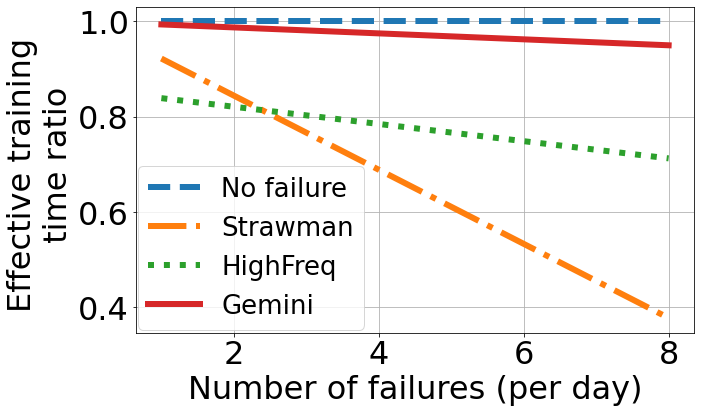

In [3]:
# Figure 14a, effective training time ratio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If you are in jupyter
%matplotlib inline

params = {'legend.fontsize': 26, 'font.size': 32}
plt.rcParams.update(params)

failures = np.array([i for i in range(1, 9)])

# 100B, 16 p4d instances

# the number of minutes in a day
total_time = 60 * 24 # min

# the effective training time ratio of GEMINI
def gemini_performance(failures):
    """
        failures: the list of the number of failures everyday
    """
    # the total overhead resulting from a failure that recovered with GEMINI
    overhead = 9 # min
    perfs = []
    for failure in failures:
        perfs.append(1 - overhead * failure / total_time)
    return perfs


# the effective training time ratio of the Strawman
def deepspeed_performance(failures):
    """
        failures: the list of the number of failures everyday
    """
    # the average total overhead resulting from a failure that recovered with a 3-hour checkpoint frequency
    # it is calculated according Expression (1)
    ckpt_time = 480  # sec
    overhead = (ckpt_time / 60) * 2 + 90 + 6 # min, 90 is 1/2f and it takes around 6 mins to restart the training
    perfs = []
    for failure in failures:
        perfs.append(1 - overhead * failure / total_time)
    return perfs


def highfreq_performance(failures):
    """
        failures: the list of the number of failures everyday
    """
    # the profiled time for saving a checkpoint with torch.save() before sending it to the remote storage system
    save_time = 80 # sec
    # the profiled time for sending a checkpoint to the remote storage system
    ckpt_time = 480  # sec
    # the overhead to recover training considering the lost training progress and the checkpoint retrieval time
    # it is calculated according Expression (1)
    overhead = (ckpt_time / 60) * 2.5 + 6 # min, it takes around 6 mins to restart the training
    perfs = [] 
    for failure in failures:
        perfs.append(ckpt_time/(save_time+ckpt_time) - overhead * failure / total_time)
    return perfs

deepspeed = deepspeed_performance(failures)
highfreq = highfreq_performance(failures)
gemini = gemini_performance(failures)
no_failure = np.array([1 for i in range(1, 9)])

df = pd.DataFrame({
    'No failure': no_failure,
    'Strawman': deepspeed,
    'HighFreq': highfreq,
    'Gemini': gemini,
   }, index=failures)

lines = df.plot.line(figsize=(10, 6), grid=True, lw=6, fontsize=32, style=['--','-.',':','-'])

# plt.xlim(0.9, 100)
lines.set_xlabel("Number of failures (per day)", fontdict={'fontsize':32})
lines.set_ylabel("Effective training \n time ratio", fontdict={'fontsize':32})
plt.legend(loc=3, ncol=1, frameon=True, bbox_to_anchor=(-0.02, -0.03))
plt.savefig("Figure_14a.png", bbox_inches='tight')

In [ ]:
# Figure 14a, effective training time ratio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If you are in jupyter
%matplotlib inline

params = {'legend.fontsize': 26, 'font.size': 32}
plt.rcParams.update(params)

# the number of minutes in a day
total_time = 60 * 24 # min

# the list of the number of machines used in the simulation
machines = [i * 100 for i in range(2, 11)]

# 1T model, 1.5% per day from training of OPT-175B, Opt: Open pre-trained transformer language models, https://arxiv.org/abs/2205.01068
failure_rate = 0.015


def gemini_performance(machines):
    """
        machines: the list of the number of machines used in the simulation
    """
    # the total overhead resulting from a failure that recovered with GEMINI
    overhead = 9 # min
    perfs = []
    for m in machines:
        failures = m * failure_rate
        perfs.append(1 - overhead * failures / total_time)
    return perfs


def deepspeed_performance(machines):
    """
        machines: the list of the number of machines used in the simulation
    """
    # the average total overhead resulting from a failure that recovered with a 3-hour checkpoint frequency
    # it is calculated according Expression (1)
    ckpt_time = 480  # sec
    overhead = (ckpt_time / 60) * 2 + 90 + 6 # min, 90 is 1/2f and it takes around 6 mins to restart the training
    perfs = []
    for m in machines:
        failures = m * failure_rate
        perfs.append(max(0, 1 - overhead * failures / total_time))
    return perfs


def highfreq_performance(machines):
    """
        machines: the list of the number of machines used in the simulation
    """
    # the profiled time for saving a checkpoint with torch.save() before sending it to the remote storage system
    save_time = 80 # sec
    # the profiled time for sending a checkpoint to the remote storage system
    ckpt_time = 480  # sec
    # the overhead to recover training considering the lost training progress and the checkpoint retrieval time
    # it is calculated according Expression (1)
    overhead = (ckpt_time / 60) * 2.5 + 6 # min, it takes around 6 mins to restart the training
    perfs = []
    for m in machines:
        failures = m * failure_rate
        perfs.append(ckpt_time/(save_time+ckpt_time) - overhead * failures / total_time)
    return perfs


deepspeed = deepspeed_performance(machines)
highfreq = highfreq_performance(machines)
gemini = gemini_performance(machines)
no_failure = np.array([1 for i in machines])

df = pd.DataFrame({
    'No failure': no_failure,
    'Strawman': deepspeed,
    'HighFreq': highfreq,
    'Gemini': gemini,
   }, index=machines)

lines = df.plot.line(figsize=(10, 6), grid=True, lw=6, fontsize=32, style=['--','-.',':','-'])

# plt.xlim(0.9, 100)
lines.set_xlabel("Number of instances", fontdict={'fontsize':32})
lines.set_ylabel("Effective training \n time ratio", fontdict={'fontsize':32})
plt.legend(loc=3, ncol=1, frameon=True, bbox_to_anchor=(-0.02, -0.03))
plt.savefig("simulation_model_size.png", bbox_inches='tight')